In [1]:
import pickle
import yaml
import datetime
import glob
import os
import pathlib

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

from tensorflow import keras as kr
from sklearn import svm
from sklearn.model_selection import train_test_split

C:\Users\Extra\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Extra\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Extra\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# Reading image files

In [2]:
with open('parameters.yaml') as yaml_data:
    params = yaml.safe_load(yaml_data)
    
TRAINING_CSV_PATH = params['paths']['TRAINING_CSV']
TEST_CSV_PATH = params['paths']['TEST_CSV']
TEST_GT_PATH = params['paths']['TEST_GT']

IMAGE_WIDTH = params['parameters']['IMAGE_WIDTH']
IMAGE_HEIGHT = params['parameters']['IMAGE_HEIGHT']

In [3]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values


In [4]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
1,00000_00001.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
2,00000_00002.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
3,00000_00003.ppm,31,31,5,5,26,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
4,00000_00004.ppm,30,32,5,6,25,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


# Training the model

In [5]:
N = 10_000
N = None # Take all

if N is None:
  images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                        axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)
else:
  images_list = build_images_list(images_df.head(N)['path'].values,
                                  images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [6]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [7]:
#Reshaping data 
X_train_size = X_train.shape[0]
X_test_size = X_test.shape[0]

X_train = X_train.reshape(X_train_size,-1)
X_test = X_test.reshape(X_test_size,-1)

In [8]:
model = svm.SVC(kernel='linear', random_state=1)
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

# Saving the model

In [9]:
def save_classifier(model, basename):
    """Save to pickle format a SVM model with a timestamp

    Paramaters
    ----------
    model: trained model
    basename: basename including path to use for filename

    Returns
    -------
    None
    """
    pickle.dump(model, open(basename, 'wb'))
 
    return

In [10]:
save_classifier(model, '../models/traffic_signs_svm.pickle')
test_model = pickle.load(open('../models/traffic_signs_svm.pickle', 'rb'))

# Testing the model

In [11]:
def classify_image(path, model, image_box=None):
  """Classify image by model

  Parameters
  ----------
  path: filepath to image
  model: SVM classifier

  Returns
  -------
  class id returned by model classifier
  """
  images_list = []
  image = Image.open(path)
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
  image = np.array(image)
  images_list.append(image)
  
  return model.predict(np.array(images_list).reshape(1, -1))

In [12]:
image_sample = images_df.sample(1)

classify_image(image_sample['path'].values[0],
               test_model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

array([8], dtype=int64)

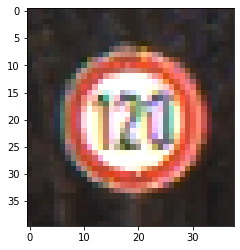

In [13]:
plt.imshow(Image.open(image_sample['path'].values[0]))

# Load test 

In [14]:
test_images_df = pd.read_csv(TEST_GT_PATH, sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x: TEST_CSV_PATH + x)
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12626,12626.ppm,50,51,6,5,45,46,33,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12627,12627.ppm,29,29,6,6,24,24,6,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12628,12628.ppm,48,49,5,6,43,44,7,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12629,12629.ppm,32,31,6,5,27,26,10,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...


In [15]:
test_list = build_images_list(test_images_df['path'].values,
                                test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)

#reshape in array for SVM
test_data_SVM = test_data.reshape(test_data.shape[0], -1)

In [16]:
results = test_model.predict(test_data_SVM)

In [17]:
(test_labels == results).sum() / test_labels.shape[0]

0.8738717339667459

# Load Neural Network model

In [18]:
test_model_NN = kr.models.load_model('../models/traffic_signs_2021-03-26_16-48-07.h5')

In [19]:
results_NN = test_model_NN.predict_classes(test_data)

C:\Users\Extra\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [23]:
(test_labels == results_NN).sum() / test_labels.shape[0]

0.9588281868566905

# Compare actual to predicted (class level) for both models

In [ ]:
# We can see that our Neural Network model is better to predict classes, in particular the following ones : 
# 0 (Speed limit (20km/h), 18 (General caution), 19 (Dangerous Curve Left), 21 (Double curve), 
# 24 (Road narrows on the right), 27 (Pedestrians), 30 (Beware of ice/snow)

# SVM model give slightly better results for : 
# 32 (End speed + passing limits) , 40 (Roundabout mandatory) , 41 (End of no passing)

# To conclude, we can say that our Neural Network model is better, but 95% of accuracy is still quite low
# to be used, in particular for a subject as sensible as a road sign in which a mistake can have big consequences.

In [20]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results
accuracy_df['predicted_NN'] = results_NN

accuracy_df.head()

,actual,predicted,predicted_NN
0,16,16,16
1,1,1,1
2,38,38,38
3,33,33,33
4,11,11,11


Text(0.5, 1, 'SVM heatmap')

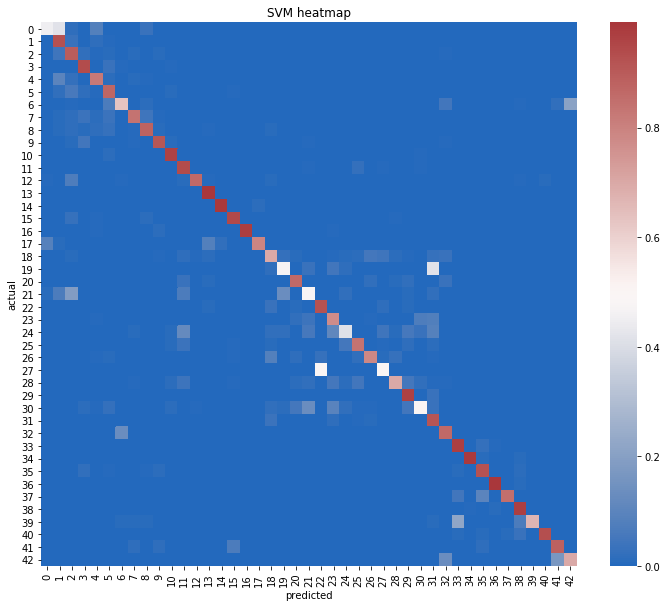

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);
ax.set_title('SVM heatmap')

Text(0.5, 1, 'NN heatmap')

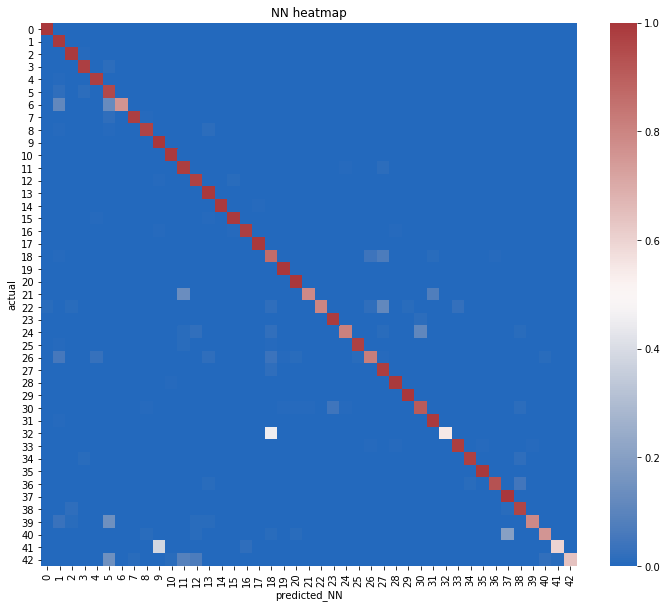

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted_NN'], normalize='index'),
            cmap='vlag',
            ax=ax);
ax.set_title('NN heatmap')